In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50

Global Constants

In [3]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 7

# Fixed for Cats & Dogs color images
CHANNELS = 7

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

ResNet50 : 
- Notice that resnet50 folder has 2 pre-trained weights files... xyz_tf_kernels.h5 & xyz_tf_kernels_NOTOP.h5
- The xyz_tf_kernels.h5 weights is useful for pure prediction of test image and this prediction will rely completely on ResNet50 pre-trained weights, i.e., it does not expected any training from our side
- Out intention in this kernel is Transfer Learning by using ResNet50 pre-trained weights except its TOP layer, i.e., the xyz_tf_kernels_NOTOP.h5 weights... Use this weights as initial weight for training new layer using train images

In [5]:
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

Define Our Transfer Learning Network Model Consisting of 2 Layers
- Here, we are preparing specification or blueprint of the TensorFlow DAG (directed acyclcic graph) for just the MODEL part.

In [6]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

#si ça marche pas, mettre 'resnet_weights_path' à la place de None dans weights 

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(800, activation='relu'))
#model.add(Dense(600, activation='sigmoid'))
#model.add(Dense(200, activation='sigmoid'))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 800)               1639200   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5607      
Total params: 25,232,519
Trainable params: 1,644,807
Non-trainable params: 23,587,712
_________________________________________________________________


Compile Our Transfer Learning Model

In [8]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

Prepare Keras Data Generators

In [9]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        '../input/images-plastic/images/images/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        '../input/images-plastic/images/images/valid',
        target_size=(image_size, image_size),
        #batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Using TensorFlow backend.


Found 273 images belonging to 7 classes.
Found 56 images belonging to 7 classes.


In [ ]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

Train Our Model With Cats & Dogs Train (splitted) Data Set

In [ ]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
#from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
#cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [11]:
checkpoint = ModelCheckpoint(
    'modelvggcifar-10.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [12]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 20,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[checkpoint]
)
#model.load_weights("../working/best.hdf5")

Epoch 1/20
3/3 [==============================] - 12s 4s/step - loss: 1.7087 - acc: 0.3223 - val_loss: 2.3800 - val_acc: 0.2143
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 1.1568 - acc: 0.6337 - val_loss: 2.3466 - val_acc: 0.3571
Epoch 3/20
3/3 [==============================] - 7s 2s/step - loss: 0.8296 - acc: 0.7692 - val_loss: 2.0290 - val_acc: 0.3929
Epoch 4/20
3/3 [==============================] - 7s 2s/step - loss: 0.5678 - acc: 0.8315 - val_loss: 1.6018 - val_acc: 0.4464
Epoch 5/20
3/3 [==============================] - 7s 2s/step - loss: 0.4389 - acc: 0.8681 - val_loss: 1.3602 - val_acc: 0.5536
Epoch 6/20
3/3 [==============================] - 7s 2s/step - loss: 0.3458 - acc: 0.9121 - val_loss: 1.3714 - val_acc: 0.5714
Epoch 7/20
3/3 [==============================] - 7s 2s/step - loss: 0.2728 - acc: 0.9524 - val_loss: 1.2087 - val_acc: 0.5893
Epoch 8/20
3/3 [==============================] - 7s 2s/step - loss: 0.2193 - acc: 0.9634 - val_loss: 1.1240 -

Définition d'une fonction pour assigner les labels des images aux bons noms 

In [13]:
def myPredict(data, mode = 0) :
    result = []
    if mode == 0 : 
        for dat in data : 
            reponse = {'bouchon' : dat[0], 'bouteille' : dat[1], 
                       'contenant' : dat[2], 'couvert' : dat[3], 
                       'film' : dat[4], 'gobelets' : dat[5], 
                       'yaourt' : dat[6]}
            result.append(reponse)
        return result

    else : 
        for dat in data :
            result.append(np.argwhere(dat==dat.max())[0][0])
        return np.array(result)

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

In [15]:
pred = model.predict_generator(validation_generator, len(validation_generator))
Ypredicted = myPredict(pred,1)



In [16]:
matrix = confusion_matrix(y_true = validation_generator.labels, 
                 y_pred =Ypredicted, 
                 labels=[0,1,2,3,4,5,6])

class_names = ['bouchon', 'bouteille', 'contenant', 'couvert', 'film', 'gobelets', 'yaourt']


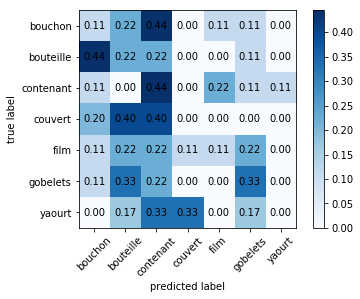

In [17]:
fig, ax = plot_confusion_matrix(conf_mat=matrix,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names)
plt.show()

In [18]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


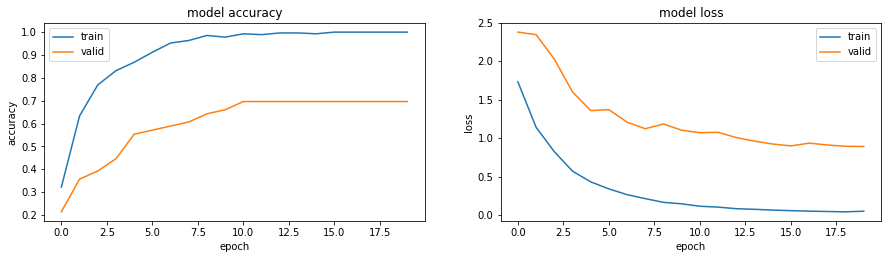

In [19]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
test_generator = data_generator.flow_from_directory(
    directory = '../Kaggle/images/images/test',
    target_size = (image_size, image_size),
    #batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    #shuffle = False,
    #seed = 123
)


In [ ]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator))

#predicted_class_indices = np.array(pred, axis = 1)

In [ ]:
TEST_DIR = '../images/images/test'
f, ax = plt.subplots(3, 3, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    #predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()
